In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam



In [76]:
def generate_synthetic_data(n_samples=1000, time_steps=1000, breakthrough_threshold=0.7):
    np.random.seed(42)
    
    time = np.arange(time_steps)
    bottomhole_pressure = 3000 - 5 * time + np.random.normal(0, 10, time_steps)
    tubing_head_pressure = 1500 - 3 * time + np.random.normal(0, 5, time_steps)
    oil_rate = 1000 - 0.5 * time + np.random.normal(0, 5, time_steps)  # Slower decline
    
    # Ensure water rate starts low and gradually increases
    water_rate = np.maximum(0, 1 + 0.02 * time**2 + np.random.normal(0, 1, time_steps))
    water_saturation = np.clip(0.1 + 0.0005 * time + np.random.normal(0, 0.002, time_steps), 0, 1)
    
    # Compute water cut but restrict initial values to <= 0.5
    water_cut = water_rate / (water_rate + oil_rate)
    water_cut = np.clip(water_cut, 0, 0.5)  # Restrict max water cut to 0.5 initially

    # Introduce controlled growth beyond a certain time step to simulate breakthrough
    breakthrough_start = int(0.7 * time_steps)  # Adjust this point as needed
    water_cut[breakthrough_start:] = np.linspace(0.5, 0.8, time_steps - breakthrough_start)  # Gradual increase

    data = pd.DataFrame({
        'Time': time,
        'BHP': bottomhole_pressure,
        'THP': tubing_head_pressure,
        'Oil_Rate': oil_rate,
        'Water_Rate': water_rate,
        'Water_Saturation': water_saturation,
        'Water_Cut': water_cut
    })
    
    return data

In [77]:
# 2️⃣ Preprocessing & Scaling
# --------------------------------------------
features = ['BHP', 'THP', 'Oil_Rate', 'Water_Rate', 'Water_Saturation', 'Water_Cut']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length, :-1].values)  # All features except target
        y.append(data.iloc[i+seq_length, -1])  # Target (Water Cut)
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Sequence window
X, y = create_sequences(df_scaled, SEQ_LENGTH)

# Train-test split
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [78]:
# 3️⃣ Build & Train LSTM Model
# --------------------------------------------
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

C:\Users\rakes\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.2147 - val_loss: 0.0241
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0197 - val_loss: 0.0018
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0137 - val_loss: 0.0181
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0059 - val_loss: 0.0471
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0542
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.6141e-04 - val_loss: 0.0333
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6681e-04 - val_loss: 0.0194
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1482e-04 - val_loss: 0.0058
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.7425e-05 - val_loss: 4.3869e-05
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4196e-05 - val_loss: 0.0012
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1645e-05 - val_loss: 0.0014
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━

In [80]:
# 4️⃣ Make Predictions & Fix Scaling Issue
# --------------------------------------------
predictions = model.predict(X_test)

# Fix scaling issue (ensure proper inverse transform)
num_features = X_test.shape[2]
temp_array = np.zeros((len(y_test), num_features + 1))
temp_array[:, :-1] = X_test[:, -1, :]
temp_array[:, -1] = y_test
y_test_rescaled = scaler.inverse_transform(temp_array)[:, -1]

temp_array[:, -1] = predictions.flatten()
predictions_rescaled = scaler.inverse_transform(temp_array)[:, -1]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [81]:
# 5️⃣ Detect Breakthrough Time
# --------------------------------------------
breakthrough_threshold = 0.7
predicted_breakthrough_time = np.argmax(predictions_rescaled > breakthrough_threshold)


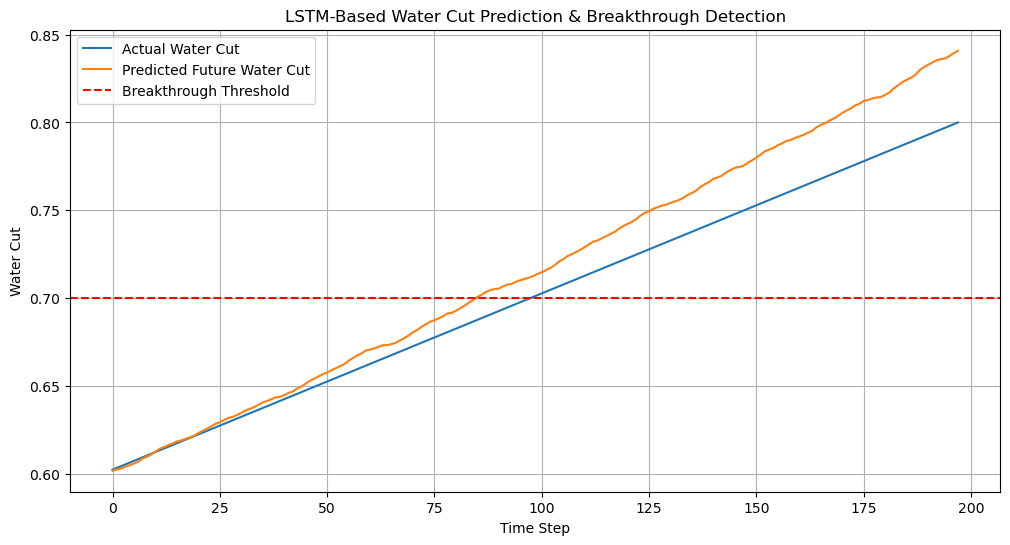

Predicted breakthrough occurs at future time step: 85


In [82]:
# 6️⃣ Plot Results
# --------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Water Cut')
plt.plot(predictions_rescaled, label='Predicted Future Water Cut')
plt.axhline(y=breakthrough_threshold, color='r', linestyle='--', label='Breakthrough Threshold')
plt.legend()
plt.title('LSTM-Based Water Cut Prediction & Breakthrough Detection')
plt.xlabel("Time Step")
plt.ylabel("Water Cut")
plt.grid()
plt.savefig("water_cut_prediction.png", dpi=300)
plt.show()

print(f'Predicted breakthrough occurs at future time step: {predicted_breakthrough_time}')
